In [1]:
import torch
torch.cuda.is_available()

False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np



# define the network

class CellClassifier(nn.Module):
    """
    A neural network for cell type classification
    """
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize the model. Here, the model is a simple feedforward neural network with 2 hidden layers.
        
        Parameters:
            input_size (int): the number of input features
            hidden_size (int): the number of neurons in the hidden layer
            num_classes (int): the number of classes to predict
        """
        super(CellClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Forward pass of the neural network
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
def get_train_test_dataloaders(data, X=None):
    """
    Convert the data into PyTorch tensors and split into training and test sets. We then return the PyTorch dataloader objects.
    
    Parameters:
        data (polars Dataframe): the data to be used for training and testing
        X: Optional parameter if we want to directly specify the predictors. This is useful for when we are not using the X directly from 
        the dataset. For example X could be the embeddings from GAE
    """
    
    # define the data loader
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.preprocessing import LabelEncoder

    biomarkers = ['1021522Tm169Di EGFR', '117792Dy163Di GATA3',
                 '1261726In113Di Histone', '1441101Er168Di Ki67', '174864Nd148Di SMA', '1921755Sm149Di Vimenti', '198883Yb176Di cleaved', '201487Eu151Di cerbB', '207736Tb159Di p53',
                 '234832Lu175Di panCyto', '3111576Nd143Di Cytoker', '312878Gd158Di Progest', '322787Nd150Di cMyc', '3281668Nd142Di Fibrone', '346876Sm147Di Keratin', '3521227Gd155Di Slug',
                 '361077Dy164Di CD20', '378871Yb172Di vWF', '473968La139Di Histone', '651779Pr141Di Cytoker', '6967Gd160Di CD44', '71790Dy162Di CD45', '77877Nd146Di CD68',
                 '8001752Sm152Di CD3epsi', '92964Er166Di Carboni', '971099Nd144Di Cytoker', '98922Yb174Di Cytoker', 'Nd145Di Twist', 'phospho S6', 'phospho mTOR']
    
    
    X = data[biomarkers].to_pandas().values if X is None else X

    # convert the biomarker data into PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)


    # convert the cell type labels into integers
    label_encoder = LabelEncoder()
    cell_type_column = 'CELL_TYPE' if 'CELL_TYPE' in data.columns else 'celltype'
    y = label_encoder.fit_transform(data[cell_type_column].to_pandas())  # convert to pandas for label encoding

    # convert the labels into PyTorch tensors
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Combine the tensors
    dataset = TensorDataset(X_tensor, y_tensor)



    # Temporarily switch default tensor type to CPU
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.FloatTensor')

    # Split the data into training and test sets
    train_size = int(0.8 * len(dataset))  # 80% for training
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Switch default tensor type back to CUDA
    if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')



    # Define your dataloaders
    batch_size = 32  # choose the batch size that suits your needs
    
    # Create a generator for the 'cuda' device
    g = torch.Generator(device)

    # Define your dataloaders with the 'cuda' generator
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=g)

    # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader
    
    
def train_model(model, train_dataloader, num_epochs=100, print_loss=True):
    """
    Train the model
    
    Parameters:
        model (nn.Module): the model to be trained
        train_dataloader (DataLoader): the dataloader for the training data
    """
    
    # Define the loss function
    loss_function = nn.NLLLoss()

    # Define the optimizer - Stochastic Gradient Descent
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(num_epochs):  # number of epochs
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)        

            # Clear the gradients from the last step
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = loss_function(outputs, targets)

            # Backward pass and update
            loss.backward()
            optimizer.step()

        if print_loss:
            # Print the loss for this epoch
            if epoch % 10 == 0:  # Only print every 10 epochs
                print('Epoch', epoch, 'Loss', loss.item())
        
        
def test_model(model, test_dataloader):
    """
    Evaluate the model
    
    Parameters:
        model (nn.Module): the model to be evaluated
        test_dataloader (DataLoader): the dataloader for the test data
    """
    
    # switch the model to evaluation mode
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # No need to track gradients for validation, saves memory and computations
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print('Test Accuracy: %.2f %%' % (100 * accuracy))
    
    return all_labels, all_preds

def test_model_thresholds(model, test_dataloader):
    """
    Evaluate the model
    
    Parameters:
        model (nn.Module): the model to be evaluated
        test_dataloader (DataLoader): the dataloader for the test data
    """
    
    # switch the model to evaluation mode
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # No need to track gradients for validation, saves memory and computations
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    # print('Test Accuracy: %.2f %%' % (100 * accuracy))
    
    return accuracy


## Predicting Cell Type

Here, as a first step, we will predict cell type in a supervised manner. We will treat the cell labels from the melanoma dataset as the ground truth and see how well the biomarkers are at predicting the cell type. In the next sections, we will work with clustering and using the biomarkers of neighboring cells as well

For the first part, we just try to predict the cell types for the first region (df_0_1_1), which is the first sample_id and first FOV_id. We use the biomarkers of the cells as the predictors for the cell type. The model that we are using here is a simple feedforward neural network with 2 hidden layers consisting of 50 neurons each. The input layer is all the biomarkers. We apply the softmax to the output layer, so we'll get probabilities for each of the classes. We take the class with the highest probability to be our predicted cell type. For this first region (df_0_1_1), we got an accuracy of around 89%. In the next stage, we also do this for the whole dataset

### Train and test the model and create visualizations

In [5]:
# for the first data (df_0_1_1)

# import pandas as pd
import polars as pl


cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")

# Define the model

input_size = 30
hidden_size = 50  # could be optimized
num_classes = len(data["CELL_TYPE"].unique())

# create the model and transfer it to GPU if avilable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(data['CELL_TYPE'].to_pandas())  # convert to pandas for label encoding
class_names = label_encoder.classes_
class_names, len(class_names)


(array(['Apoptotic', 'Basal CK', 'CK lo HR hi p53+', 'CK lo HR lo',
        'CK+ HR hi', 'CK+ HR lo', 'CK+ HR+', 'CK7+', 'Endothelial',
        'Epithelial low', 'Fibronectin hi', 'Macrophage', 'Myoepithelial',
        'Proliferative', 'Small circular', 'Small elongated',
        'T & B cells', 'T cell', 'Vimentin hi'], dtype=object),
 19)

Epoch 0 Loss 1.5193299055099487
Epoch 10 Loss 1.544083595275879
Epoch 20 Loss 1.4632660150527954
Epoch 30 Loss 1.6386867761611938
Epoch 40 Loss 1.020629644393921
Epoch 50 Loss 1.94729483127594
Epoch 60 Loss 1.7210639715194702
Epoch 70 Loss 1.5946745872497559
Epoch 80 Loss 0.3634941875934601
Epoch 90 Loss 0.562797486782074
Epoch 100 Loss 0.9371087551116943
Epoch 110 Loss 1.4295134544372559
Epoch 120 Loss 0.7048559188842773
Epoch 130 Loss 0.8051474690437317
Epoch 140 Loss 1.490196704864502
Epoch 150 Loss 0.43074098229408264
Epoch 160 Loss 0.8722793459892273
Epoch 170 Loss 1.289514422416687
Epoch 180 Loss 1.2054988145828247
Epoch 190 Loss 0.3765702247619629
Test Accuracy: 55.95 %


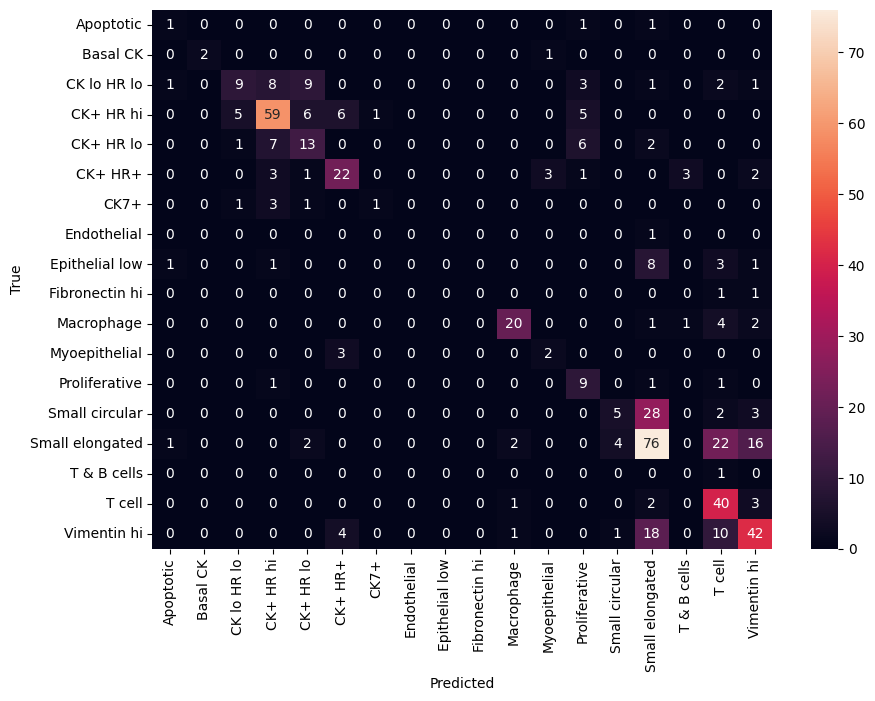

In [6]:
# get the train and test dataloaders
train_dataloader, test_dataloader = get_train_test_dataloaders(data)

# Train the model
train_model(model, train_dataloader, num_epochs=200)

# Get the true and predicted labels
true_labels, predicted_labels = test_model(model, test_dataloader)

# Get unique classes in true and predicted labels
unique_classes = np.unique(np.concatenate((np.unique(true_labels), np.unique(predicted_labels))))

# Get the corresponding class names
unique_class_names = label_encoder.inverse_transform(unique_classes)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels, labels=unique_classes)

# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_class_names, yticklabels=unique_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Using K-fold cross validation

In [14]:
from sklearn.model_selection import KFold

def train_test_model_k_fold(dataset, input_size, hidden_size=50, num_classes=16, k=5, num_epochs=100, print_loss=True):
    """
    Train and test the model using K-Fold cross-validation
    
    Parameters:
        dataset (torch.utils.data.Dataset): the dataset for training and testing
        input_size (int): number of input features
        hidden_size (int): number of nodes in a hidden layer
        num_classes (int): number of classes (output dimension)
        k (int): the number of folds for cross-validation
        num_epochs (int): the number of epochs for training
        print_loss (bool): whether to print the loss during training
    """
    
    # Define the loss function
    loss_function = nn.NLLLoss()

    # Define K-Fold cross-validation
    kfold = KFold(n_splits=k, shuffle=True)

    accuracies = []

    # K-Fold cross-validation loop
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
         # create the model and transfer it to GPU if avilable
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = CellClassifier(input_size, hidden_size, num_classes).to(device)
        
        # Define the optimizer - Stochastic Gradient Descent
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Define data loaders for training and testing data in this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        train_loader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=10, sampler=test_subsampler)

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)        

                # Clear the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                loss = loss_function(outputs, targets)

                # Backward pass and update
                loss.backward()
                optimizer.step()

            if print_loss:
                # Print the loss for this epoch
                if epoch % 10 == 0:  # Only print every 10 epochs
                    print('Epoch', epoch, 'Loss', loss.item())

        # Evaluation for this fold
        correct, total = 0, 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)
        print(f'Accuracy for fold {fold}: {accuracy * 100}%')

    print('--------------------------------')
    print('FINAL RESULTS')
    print(f'Average accuracy across {k}-folds: {np.mean(accuracies) * 100}%')
    print('--------------------------------')

    return accuracies


In [21]:
import polars as pl


cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset

# List of biomarkers
biomarkers = ['CD45', 'CD3', 'CD4', 'CD8', 'FOXP3', 'CD56', 'CD20', 'CD14', 'CD163', 'CD68', 
              'SOX10', 'S100B', 'KI67', 'CD25', 'PD1', 'LAG3', 'TIM3', 'CD27', 'PDL1', 'B7H3', 
              'IDO1', 'B2M', 'MHCI', 'MHCII', 'MRC1', 'TGM2']

# Extract biomarker data and convert to tensor
X = data_without_unknown[biomarkers].to_pandas().values
X_tensor = torch.tensor(X, dtype=torch.float)

# Convert cell type labels into integers and then to tensor
label_encoder = LabelEncoder()
cell_type_column = 'CLUSTER_LABEL' if 'CLUSTER_LABEL' in data_without_unknown.columns else 'celltype'
y = label_encoder.fit_transform(data_without_unknown[cell_type_column].to_pandas())
y_tensor = torch.tensor(y, dtype=torch.long)


model = CellClassifier(input_size, hidden_size, num_classes).to(device)
dataset = TensorDataset(X_tensor, y_tensor)
accuracies = train_test_model_k_fold(dataset, input_size=26, hidden_size=50, num_classes=15, k=5, num_epochs=200)


FOLD 0
--------------------------------
Epoch 0 Loss 0.22503149509429932
Epoch 10 Loss 0.15612636506557465
Epoch 20 Loss 0.006797758862376213
Epoch 30 Loss 0.05641729012131691
Epoch 40 Loss 0.01518623623996973
Epoch 50 Loss 0.20336897671222687
Epoch 60 Loss 8.391105802729726e-05
Epoch 70 Loss 0.10696584731340408
Epoch 80 Loss 0.001397335552610457
Epoch 90 Loss 0.247292160987854
Epoch 100 Loss 0.0029157965909689665
Epoch 110 Loss 0.002568470314145088
Epoch 120 Loss 0.008840986527502537
Epoch 130 Loss 0.03521523252129555
Epoch 140 Loss 0.049086153507232666
Epoch 150 Loss 0.004066826310008764
Epoch 160 Loss 5.758856059401296e-05
Epoch 170 Loss 0.01656331866979599
Epoch 180 Loss 2.046417193923844e-06
Epoch 190 Loss 0.0007665029261261225
Accuracy for fold 0: 94.43757725587145%
FOLD 1
--------------------------------
Epoch 0 Loss 0.2155313938856125
Epoch 10 Loss 0.09443005919456482
Epoch 20 Loss 0.3043608069419861
Epoch 30 Loss 0.049135178327560425
Epoch 40 Loss 0.683258593082428
Epoch 50 Lo

Now that we have tried predicting the cell type (assuming we know the ground truth) for one of the regions, we will now predict the cell type using the biomarkers for the entire dataset.

In [18]:
# for the whole dataset (Melanoma_Final)

data_melanoma_final = pl.read_csv("/juno/work/shah/users/ibrahih3/melanoma/Melanoma_FINAL.csv")


# Define the model

input_size = 26
hidden_size = 50  # could be optimized
num_classes = len(data_melanoma_final["celltype"].unique())
    
# check if a GPU is available and if not, we will use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)

train_dataloader, test_dataloader = get_train_test_dataloaders(data_melanoma_final)

train_model(model, train_dataloader)
test_model(model, train_dataloader)


### Probabilistic Approach (needs some work)

Here, we are still assuming that we know the ground truth of the cell types and we'll try to predict them using the biomarkers. But unlike in the previous step, we take a probabilistic approach here. That means our neural network for predicting the cell types is probabilistic. Instead of learning a single value for the weights and biases of the network, we'll instead learn a distribution over these parameters. Then when we do the forward pass for predicting, we'll sample from the learned distribution and use that in our forward pass to make predictions.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn.functional as F


class BayesianCellClassifier(PyroModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BayesianCellClassifier, self).__init__()
        self.fc1 = PyroModule[nn.Linear](input_size, hidden_size)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroModule[nn.Linear](hidden_size, hidden_size)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_size, hidden_size]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_size]).to_event(1))
        
        self.fc3 = PyroModule[nn.Linear](hidden_size, num_classes)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([num_classes, hidden_size]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
        return x

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

def train(model, train_loader, num_epochs=100):
    guide = AutoDiagonalNormal(model)  # you can try other types of guides

    optim = Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in train_loader:
            epoch_loss += svi.step(x, y)

        print(f"Epoch {epoch}: Loss {epoch_loss / len(train_loader)}")

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            total += y.shape[0]
    print(f"Accuracy: {correct / total}")


In [73]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')


In [80]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn.functional as F

class BayesianNet(PyroModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_size, hidden_size)
        self.fc1.weight = PyroSample(dist.Normal(0., 10.).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_size]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](hidden_size, hidden_size)
        self.fc2.weight = PyroSample(dist.Normal(0., 10.).expand([hidden_size, hidden_size]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_size]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](hidden_size, num_classes)
        self.fc3.weight = PyroSample(dist.Normal(0., 10.).expand([num_classes, hidden_size]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
        return x
    
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your model
model = BayesianNet(input_size=26, hidden_size=50, num_classes=16).to(device)

train_dataloader, test_dataloader = get_train_test_dataloaders(data)

# Define the guide function
guide = AutoDiagonalNormal(model)
guide.to(device)  # move the guide to the device

# Define the optimizer
optimizer = pyro.optim.Adam({"lr": 0.01})

from pyro.infer import SVI, Trace_ELBO

# Define the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, targets in train_dataloader:
        # Move inputs and targets to device
        inputs, targets = inputs.to(device), targets.to(device)
        # Perform a step of SVI (this will update the parameters of the model and guide)
        loss = svi.step(inputs, targets)
        epoch_loss += loss
    # Print the loss for this epoch
    print(f'Epoch {epoch+1}, Loss {epoch_loss/len(train_dataloader)}')


# Testing loop
model.eval()  # put the model in evaluation mode
total = 0
correct = 0

with torch.no_grad():  # deactivate autograd engine to reduce memory usage and speed up computations
    for inputs, targets in test_dataloader:
        # Move inputs and targets to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Run the model on the inputs
        outputs = model(inputs)

        # Get the most probable class
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Epoch 1, Loss 1153577.3693122228
Epoch 2, Loss 140522.5673455556
Epoch 3, Loss 93143.27255147298
Epoch 4, Loss 73075.84564317067
Epoch 5, Loss 63809.921775531766
Epoch 6, Loss 57417.603322410585
Epoch 7, Loss 50666.00684041977
Epoch 8, Loss 46824.4776913325
Epoch 9, Loss 42494.26808493932
Epoch 10, Loss 39669.84567184448
Epoch 11, Loss 37670.689437770845
Epoch 12, Loss 35767.187468338016
Epoch 13, Loss 33995.10182091395
Epoch 14, Loss 32601.17446378072
Epoch 15, Loss 30736.428320821127
Epoch 16, Loss 30411.370194180807
Epoch 17, Loss 28861.901361497243
Epoch 18, Loss 27319.07685699463
Epoch 19, Loss 27599.046328512828
Epoch 20, Loss 26752.82081906001
Epoch 21, Loss 24931.98609345754
Epoch 22, Loss 25718.438328838347
Epoch 23, Loss 23674.41607729594
Epoch 24, Loss 23781.88521531423
Epoch 25, Loss 23683.860171254477
Epoch 26, Loss 22579.92921295166
Epoch 27, Loss 22602.605617491405
Epoch 28, Loss 22509.669765059152
Epoch 29, Loss 22377.997239557903
Epoch 30, Loss 21242.38937562307
Epoch 

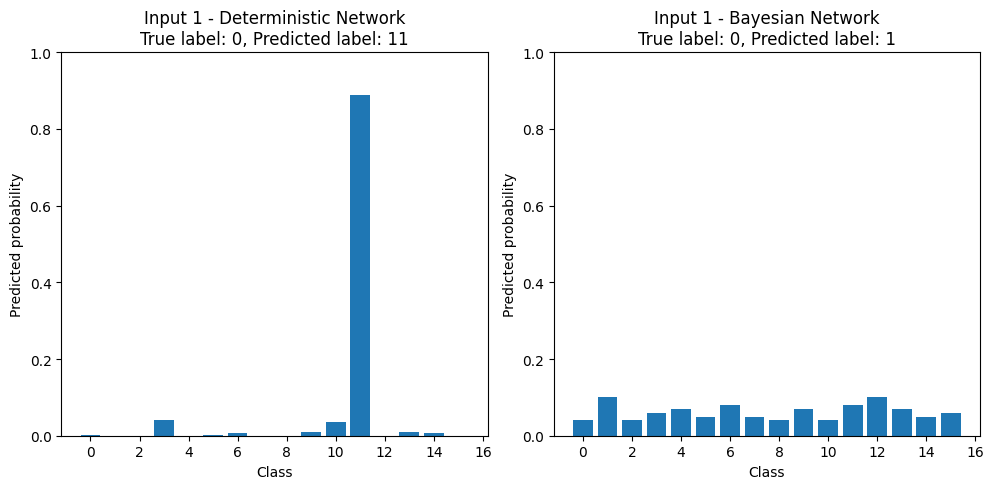

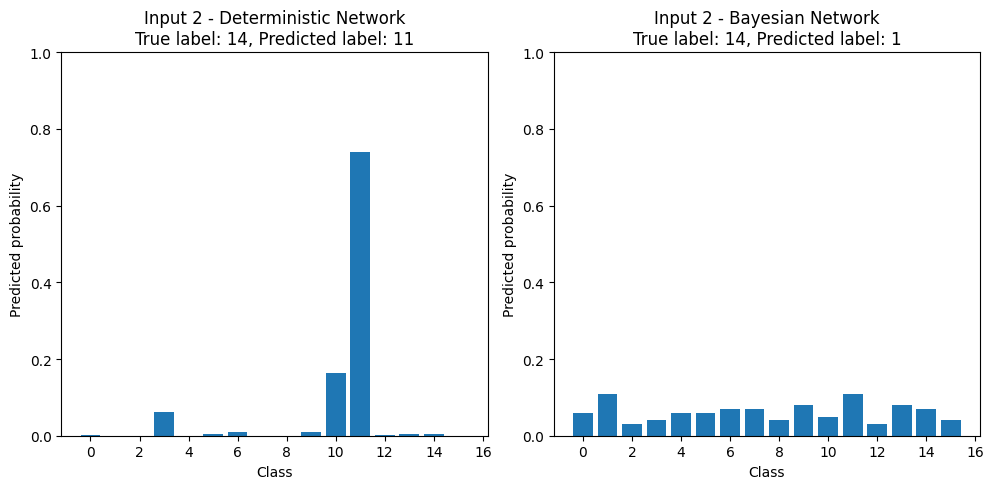

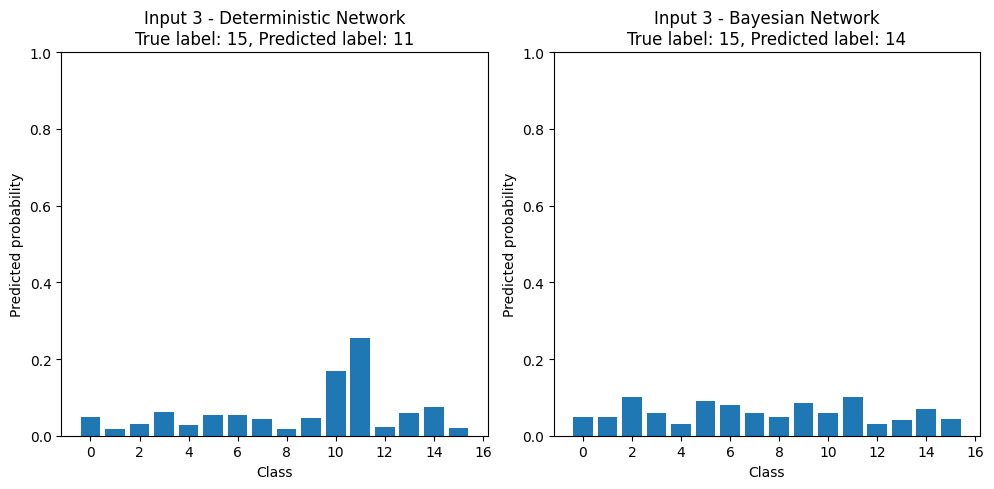

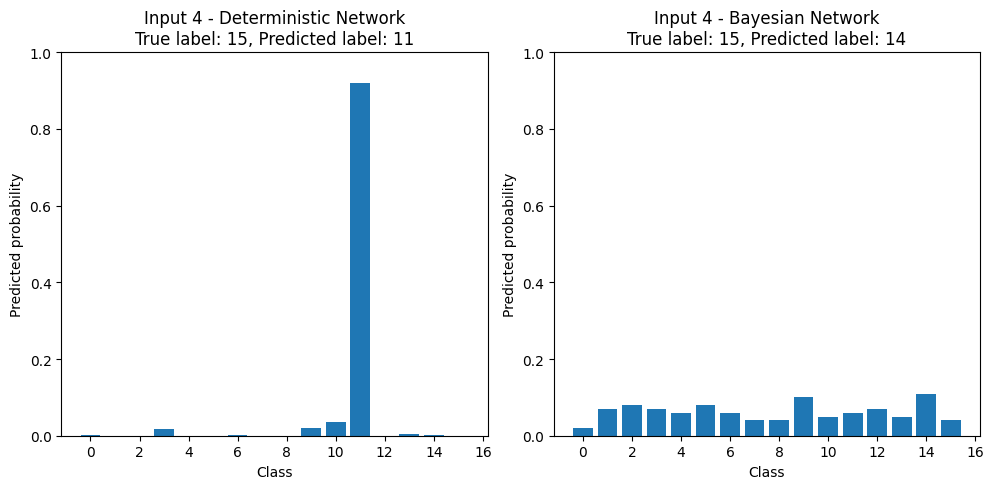

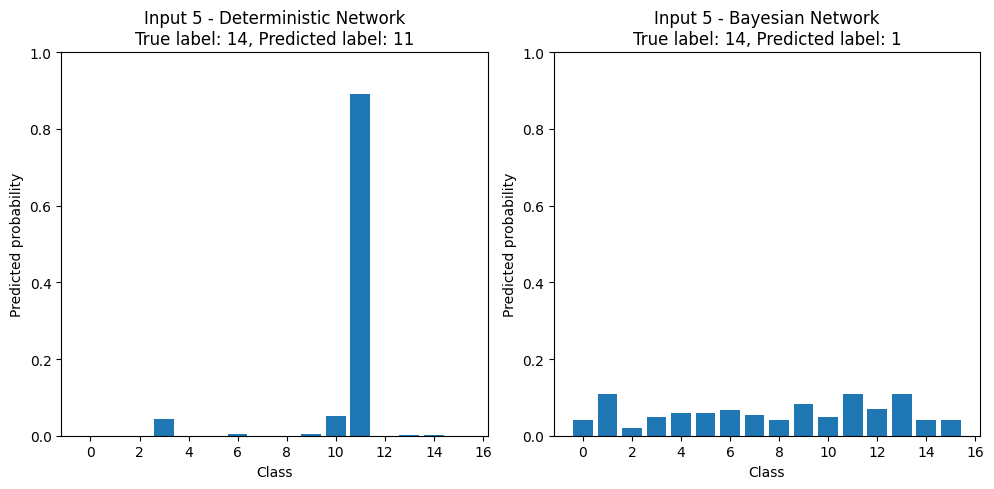

In [21]:
import matplotlib.pyplot as plt

# we'll select the first 5 inputs in our test set
inputs, targets = next(iter(test_dataloader))
inputs = inputs[20:25]#.to(device)
targets = targets[20:25]

# Forward pass through deterministic neural network
model_deterministic = CellClassifier(26,50,16)
model_deterministic.eval()  # make sure the model is in eval mode
with torch.no_grad():
    outputs_det = torch.exp(model_deterministic(inputs))  # we use exp because our model uses log_softmax

# Forward pass through Bayesian neural network
model_bayesian = BayesianNet(input_size=26, hidden_size=50, num_classes=16)
model_bayesian.eval()
with torch.no_grad():
    # draw 100 samples
    outputs_bayesian_samples = [model_bayesian(inputs) for _ in range(100)]
    # convert list of tensors into tensor
    outputs_bayesian_samples = torch.stack(outputs_bayesian_samples)

# Predicted labels
predicted_labels_det = outputs_det.argmax(dim=1)
predicted_labels_bayesian = outputs_bayesian_samples.mean(0).argmax(dim=1)

# Plot the predictions
for i in range(5):  # for each of the 5 inputs
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(16), outputs_det[i].cpu().numpy())
    plt.ylim([0, 1])
    plt.title(f"Input {i+1} - Deterministic Network\nTrue label: {targets[i].item()}, Predicted label: {predicted_labels_det[i].item()}")
    plt.xlabel("Class")
    plt.ylabel("Predicted probability")

    plt.subplot(1, 2, 2)
    # Calculate the mean softmax over the Bayesian samples to get an expected probability
    softmax_samples = torch.softmax(outputs_bayesian_samples, dim=-1)
    outputs_bayesian_mean = softmax_samples.mean(dim=0)
    plt.bar(range(16), outputs_bayesian_mean[i].cpu().numpy())
    plt.ylim([0, 1])
    plt.title(f"Input {i+1} - Bayesian Network\nTrue label: {targets[i].item()}, Predicted label: {predicted_labels_bayesian[i].item()}")
    plt.xlabel("Class")
    plt.ylabel("Predicted probability")

    plt.tight_layout()
    plt.show()


## Clustering methods

In this phase, we will now assume that we don't know the cell types and we will use clustering methods

In the first part, we use TSNE to reduce the dimensions of our biomarkers from 26 to 2 help us visualize the biomarker space in 2D. We the project the already labeled cells onto the 2D plane to see how well they cluster. We do see that the labeled cell types do indeed form a cluster, but we can't really say with full confidence that the labeled datset is right or wrong

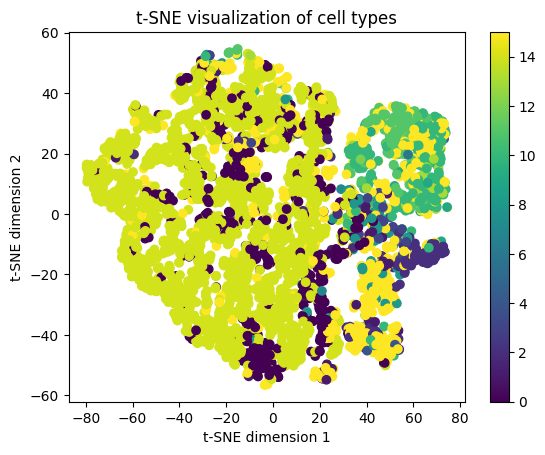

In [23]:
# to see how the labels are clustered, here we use t-SNE to reduce the dimension to components and overlay it with the 16 labeled components

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# let's assume X is your 26-dimensional input data
X = data[biomarkers].to_pandas().values  # convert to pandas for .values

# Apply t-SNE to X
tsne = TSNE(n_components=2, random_state=0)  # set n_components to 2 for a 2D visualization
X_tsne = tsne.fit_transform(X)

# Plot the result
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')  # color points by their true labels (if available)
plt.colorbar()
plt.title('t-SNE visualization of cell types')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

If we don't use any labels, then we'd see the following clusters. It's not really distinctive in that we clearly see how many clusters there are, so we can't tell for sure how many cell types there really are

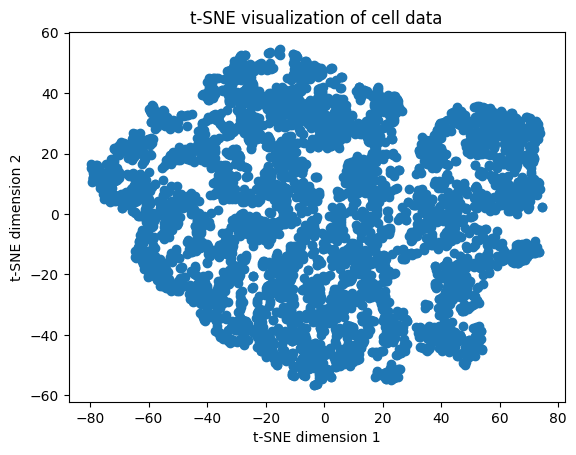

In [25]:
# without using any labels

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE visualization of cell data')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

If we then use the t-SNE data (the data whose dimension is reduced from 26 to 2) and use k means clustering by specifying the value for k, we'd get the following. I tried this for different values of k, and the clusters change a bit, but for the main part, we do see that there are clusters. We just can't conclusively say how many

/home/ibrahih3/python/envs/space-env2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


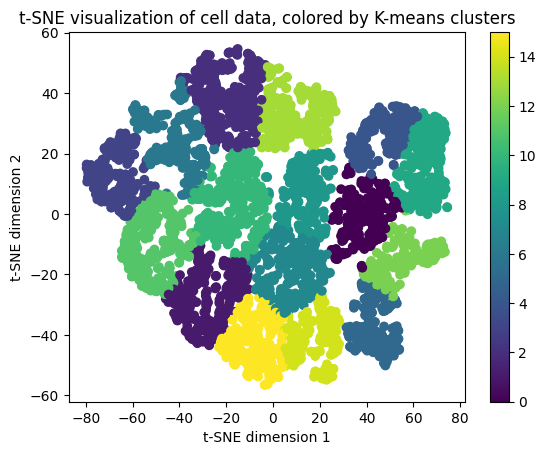

In [29]:
# using k means clustering on the t-SNE transformed data and choosing 16 clusters

from sklearn.cluster import KMeans

# Apply K-means to the 2D t-SNE data
kmeans = KMeans(n_clusters=16, random_state=0)  # choose the number of clusters
cluster_labels = kmeans.fit_predict(X_tsne)

# Plot the t-SNE data, colored by K-means cluster labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE visualization of cell data, colored by K-means clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Here, instead of applying k means clustering on the t-SNE data, I applied to to the original data with 26 dimensions to see if the clusters would change, but they remain mostly similar with the previous method

/home/ibrahih3/python/envs/space-env2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


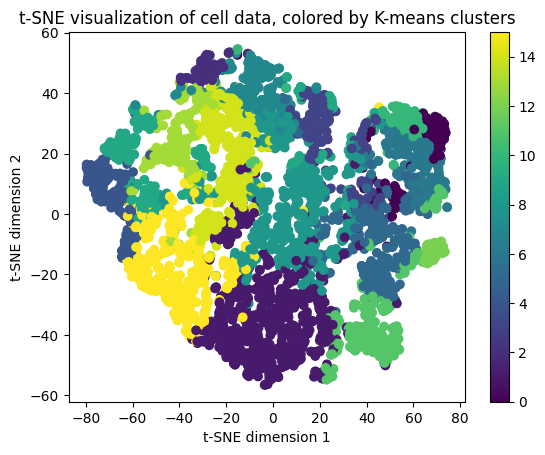

In [31]:
# k means on the original data and choosing 16 clusters

from sklearn.cluster import KMeans

# Apply K-means to the original data
kmeans = KMeans(n_clusters=16, random_state=0)  # choose the number of clusters
cluster_labels = kmeans.fit_predict(X)

# Apply t-SNE to the original data
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE data, colored by K-means cluster labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE visualization of cell data, colored by K-means clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

### Cell type prediction using biomarkers of neighbors as well

Next, I'll use the biomarkers of the neighboring cells in addition to the cell itself. We'll use multiple methods for this. We'll use simple concatanation of neighbor biomarkers using different methods of aggregation. We'll also use a GAE to get a representation that takes into account neighborhood information as well. This will also allow us how far away we want to look. If we have a single layer, it'll only look to its immediate neighbors' biomarkers to get its embedding

To get biomarker information from the neighbors of the cells, we need to create the graph. Here, I calculate the distance between each cell and use a threshold to determine which cells should be neighbors

In [19]:
import numpy as np
import pandas as pd
import polars as pl
from scipy.spatial import distance_matrix
import networkx as nx

# Read in the data
coordinates_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_coords.csv")
expressions_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

coordinates = coordinates_with_id[['X', 'Y']]
# biomarkers = expressions_with_id.columns[2:]

def create_graph_from_coordinates(coordinates_df, threshold, expressions_df):
    """
    Create a graph from the coordinates of the cells.
    
    Args:
        coordinates_df (pd.DataFrame): A DataFrame with the columns 'X' and 'Y'.
        threshold (int): The distance threshold for two cells to be connected.
        expressions_df (pd.DataFrame): A DataFrame containing the columns ACQUISITION_ID, CELL_ID, and the biomarkers.
        
    Returns:
        nx.Graph: A graph with the cells as nodes and edges between cells that are within the distance threshold.
    """
    # Compute the distance matrix
    dist_matrix = distance_matrix(coordinates_df.values, coordinates_df.values)
    # print(dist_matrix)
    
    # Create an adjacency matrix based on the distance threshold
    adjacency_matrix = (dist_matrix < threshold).astype(int)
    # print(adjacency_matrix)
    
    # Remove self-loops by setting the diagonal to zero
    # np.fill_diagonal(adjacency_matrix, 0)
    
    # Convert adjacency matrix to DataFrame
    adjacency_df = pd.DataFrame(adjacency_matrix, index=coordinates_df.index, columns=coordinates_df.index)
    
    # Create a graph from the adjacency matrix
    graph = nx.from_pandas_adjacency(adjacency_df)
    
    biomarkers = ['1021522Tm169Di EGFR', '117792Dy163Di GATA3',
                 '1261726In113Di Histone', '1441101Er168Di Ki67', '174864Nd148Di SMA', '1921755Sm149Di Vimenti', '198883Yb176Di cleaved', '201487Eu151Di cerbB', '207736Tb159Di p53',
                 '234832Lu175Di panCyto', '3111576Nd143Di Cytoker', '312878Gd158Di Progest', '322787Nd150Di cMyc', '3281668Nd142Di Fibrone', '346876Sm147Di Keratin', '3521227Gd155Di Slug',
                 '361077Dy164Di CD20', '378871Yb172Di vWF', '473968La139Di Histone', '651779Pr141Di Cytoker', '6967Gd160Di CD44', '71790Dy162Di CD45', '77877Nd146Di CD68',
                 '8001752Sm152Di CD3epsi', '92964Er166Di Carboni', '971099Nd144Di Cytoker', '98922Yb174Di Cytoker', 'Nd145Di Twist', 'phospho S6', 'phospho mTOR']
    
    # Add node features for each cell (node)
    for node in graph.nodes:
        graph.nodes[node]['features'] = expressions_df.loc[node, biomarkers].values
    
    return graph

graph = create_graph_from_coordinates(coordinates, 30, expressions_with_id)

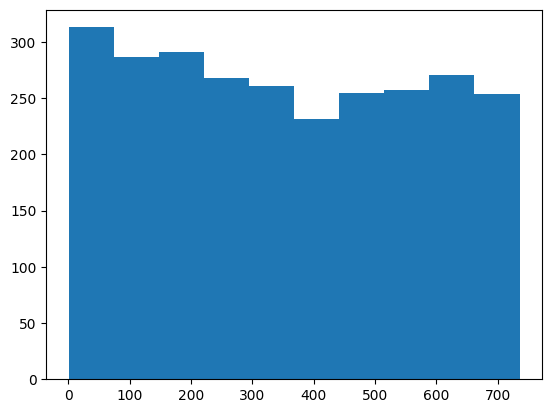

In [11]:
import matplotlib.pyplot as plt

plt.hist(coordinates_with_id['X'])
plt.show()

# coordinates_with_id['X']

First, we'll use a GAE to get embedings of the cells that take into account neighborhood biomarker information

In [10]:
import torch_geometric.utils as utils

data = utils.from_networkx(graph)

# Convert list of features to a PyTorch tensor
features_tensor = torch.tensor(data.features, dtype=torch.float)

# Add the features tensor to the Data object as the 'x' attribute
data.x = features_tensor


from torch_geometric.nn import GCNConv, GAE

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

out_channels = 16
encoder = Encoder(data.num_features, out_channels)
model = GAE(encoder)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the training loop
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(400):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")


embeddings = model.encode(data.x, data.edge_index)

/tmp/ipykernel_54039/1205688593.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  features_tensor = torch.tensor(data.features, dtype=torch.float)


Epoch: 0, Loss: 34.538787841796875
Epoch: 10, Loss: 34.538787841796875
Epoch: 20, Loss: 34.538787841796875
Epoch: 30, Loss: 34.538787841796875
Epoch: 40, Loss: 34.538787841796875
Epoch: 50, Loss: 34.538787841796875
Epoch: 60, Loss: 34.538787841796875
Epoch: 70, Loss: 34.538787841796875
Epoch: 80, Loss: 34.538787841796875
Epoch: 90, Loss: 34.538787841796875
Epoch: 100, Loss: 34.538787841796875
Epoch: 110, Loss: 34.538787841796875
Epoch: 120, Loss: 34.538787841796875
Epoch: 130, Loss: 34.538787841796875
Epoch: 140, Loss: 34.538787841796875
Epoch: 150, Loss: 34.538787841796875
Epoch: 160, Loss: 34.538787841796875
Epoch: 170, Loss: 34.538787841796875
Epoch: 180, Loss: 34.538787841796875
Epoch: 190, Loss: 34.538787841796875
Epoch: 200, Loss: 34.538787841796875
Epoch: 210, Loss: 34.538787841796875
Epoch: 220, Loss: 34.538787841796875
Epoch: 230, Loss: 34.538787841796875
Epoch: 240, Loss: 34.538787841796875
Epoch: 250, Loss: 34.538787841796875
Epoch: 260, Loss: 34.538787841796875
Epoch: 270, 

For each cell we now have 16 features that take into account neighborhood biomarker information

In [11]:
embeddings.shape

torch.Size([4783, 16])

We can now use these embeddings that incorporate neighborhood information in cell prediction

In [91]:
# def get_train_test_dataloaders(data, X=None):
#     """
#     Convert the data into PyTorch tensors and split into training and test sets. We then return the PyTorch dataloader objects.
    
#     Parameters:
#         data (polars Dataframe): the data to be used for training and testing
#     """
    
#     # define the data loader
#     from torch.utils.data import TensorDataset, DataLoader
#     from sklearn.preprocessing import LabelEncoder

#     biomarkers = ['CD45', 'CD3', 'CD4', 'CD8', 'FOXP3', 'CD56', 'CD20', 'CD14', 'CD163', 'CD68', 
#               'SOX10', 'S100B', 'KI67', 'CD25', 'PD1', 'LAG3', 'TIM3', 'CD27', 'PDL1', 'B7H3', 
#               'IDO1', 'B2M', 'MHCI', 'MHCII', 'MRC1', 'TGM2']
    
    
#     X = data[biomarkers].to_pandas().values if X is None else X

#     # convert the biomarker data into PyTorch tensors
#     X_tensor = torch.tensor(X, dtype=torch.float)


#     # convert the cell type labels into integers
#     label_encoder = LabelEncoder()
#     cell_type_column = 'CLUSTER_LABEL' if 'CLUSTER_LABEL' in data.columns else 'celltype'
#     y = label_encoder.fit_transform(data[cell_type_column].to_pandas())  # convert to pandas for label encoding

#     # convert the labels into PyTorch tensors
#     y_tensor = torch.tensor(y, dtype=torch.long)

#     # Combine the tensors
#     dataset = TensorDataset(X_tensor, y_tensor)


#     # Split the data into training and test sets
#     train_size = int(0.8 * len(dataset))  # 80% for training
#     test_size = len(dataset) - train_size
#     train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#     # Define your dataloaders
#     batch_size = 32  # choose the batch size that suits your needs
#     train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
#     return train_dataloader, test_dataloader

In [92]:
import polars as pl
cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")
data.head()

CELL_ID,CLUSTER_LABEL,ACQUISITION_ID,CD45,CD3,CD4,CD8,FOXP3,CD56,CD20,CD14,CD163,CD68,SOX10,S100B,KI67,CD25,PD1,LAG3,TIM3,CD27,PDL1,B7H3,IDO1,B2M,MHCI,MHCII,MRC1,TGM2
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""000833cf8d5424…","""Tconv8""","""df_0_1_1""",3.554053,36.304056,0.797297,87.1045,0.0493827,0.0,0.0,8.560791,13.331108,5.52239,5.90123,49.1194,9.07407,5.554052,0.878378,2.959459,29.1045,2.006756,0.268657,8.08955,0.0,24.9552,99.3433,27.750005,13.749991,0.378378
"""002287d8a57a52…","""Tumor""","""df_0_1_1""",0.0,0.4,0.003774,0.168675,0.0,0.0,0.0,0.51698,0.0,0.325301,21.6593,36.905656,67.9615,0.109434,0.041509,0.162264,7.79518,0.505661,0.060241,14.0723,0.049057,10.494,64.2048,0.011321,6.358492,0.086792
"""00295b12f4ecf5…","""Adipo_Lang""","""df_0_1_1""",0.0,0.366848,0.0,0.294643,0.0,0.0,0.0,0.451087,0.0,1.15179,10.5586,36.100544,50.625,0.076087,0.029891,0.347826,4.05357,0.043478,0.0178571,11.7679,0.0,4.0625,28.9911,0.054348,4.875,0.054348
"""0030dccd41cea2…","""Tumor""","""df_0_1_1""",0.0,0.324675,0.0,0.114286,0.0119048,0.006493,0.0,1.038961,0.0,0.114286,26.9405,42.4286,7.71429,0.62987,0.110389,0.662337,4.04286,0.285714,0.0142857,13.3857,0.006493,5.11429,37.6857,0.0,4.681816,0.045455
"""003e872c6378b6…","""Tumor""","""df_0_1_1""",0.0,1.260136,0.060811,0.430556,0.0197368,0.131757,0.0,3.925677,0.594594,3.84722,15.375,81.212877,75.6053,3.618241,0.189189,0.179054,9.60417,0.398648,0.0902778,4.13889,0.003378,8.45139,49.2222,5.337835,7.489865,0.435811


In [13]:
cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")

# Define the model

input_size = 30
hidden_size = 50  # could be optimized
num_classes = len(data["CELL_TYPE"].unique())

# create the model and transfer it to GPU if avilable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)

# get the train and test dataloaders
train_dataloader, test_dataloader = get_train_test_dataloaders(data, embeddings) # Here, X is the embeddings we got from the GAE


train_model(model, train_dataloader, num_epochs=200)
_, _ = test_model(model, test_dataloader)

NameError: name 'embeddings' is not defined

### Next, we can use simple concatenation of biomarkers from the neighbors of a cell. We will use diffrent aggregation methods (mean, sum, and max) and concatenate that with the original node's embeddinembedding. We then use this to make the predictions (Mean, sum, max)

In [14]:
# use concatenation of embeddings to predict cell type

import torch_geometric.utils as utils

def get_new_embedding(data, G, aggr='mean'):
    """
    Concatenate the embeddings of the nodes in the graph to get a new embedding
    
    Args:
        data (torch_geometric.data.Data): the data object containing the node features
        G (networkx.classes.graph.Graph): the graph used to get the neighbors of each node
        aggr (str): the aggregation method to use for the neighbors' embeddings. Can be 'mean', 'sum', or 'max'
        
    Returns:
        new_embeddings (list): a list of the new embeddings for each node in the graph
    """
    
    neighbors_dict = {node: list(neighbors.keys()) for node, neighbors in G.adjacency()}  # get all the neighbors of the current node
    new_embeddings = []
    
    for node in neighbors_dict:
        node_embedding = data.x[node]
        neighbors = neighbors_dict[node][1:]  # remove the current node from the neighbors
        neighbor_embeddings = data.x[neighbors]          
        
        if len(neighbor_embeddings) > 0:
            if aggr == 'mean':
                neighbor_embeddings_aggregated = torch.mean(neighbor_embeddings, dim=0)
            elif aggr == 'sum':
                neighbor_embeddings_aggregated = torch.sum(neighbor_embeddings, dim=0)
            elif aggr == 'max':
                neighbor_embeddings_aggregated = torch.max(neighbor_embeddings, dim=0)[0]
        else:
            # Handle the case where a node has no neighbors
            # Adjust the dimensions as necessary
            neighbor_embeddings_aggregated = torch.zeros_like(data.x[node])
                
        new_embedding = torch.cat((node_embedding, neighbor_embeddings_aggregated), dim=0)
        new_embeddings.append(new_embedding)
        
    # return a tensor object of the new embeddings
    return torch.stack(new_embeddings)

# Read in the data
coordinates_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_coords.csv")
expressions_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")

coordinates = coordinates_with_id[['X', 'Y']]

graph = create_graph_from_coordinates(coordinates, 30, expressions_with_id)
G = utils.from_networkx(graph)

# Convert list of features to a PyTorch tensor
G.features = np.array(G.features).astype(float)
features_tensor = torch.tensor(G.features, dtype=torch.float)

# Add the features tensor to the Data object as the 'x' attribute
G.x = features_tensor

# get the new embeddings

new_embeddings_mean = get_new_embedding(G, graph, aggr='mean')
new_embeddings_sum = get_new_embedding(G, graph, aggr='sum')
new_embeddings_max = get_new_embedding(G, graph, aggr='max')

[[  0.          12.0248054   20.92019905 ... 873.49873821 909.32301326
  957.49866452]
 [ 12.0248054    0.           8.9072146  ... 868.59271787 903.64446812
  951.08798981]
 [ 20.92019905   8.9072146    0.         ... 865.61279155 900.06559753
  946.93677727]
 ...
 [873.49873821 868.59271787 865.61279155 ...   0.          72.79349227
  153.85243435]
 [909.32301326 903.64446812 900.06559753 ...  72.79349227   0.
   81.10846722]
 [957.49866452 951.08798981 946.93677727 ... 153.85243435  81.10846722
    0.        ]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


Here, we can see that the shape of the embeddings that we get by concatenating the features of a node with the features of its neighbors using different aggregation methods is (num_of_cells, 52). The 52 is because we are doubling the features due to concatenation

In [15]:
new_embeddings_mean.shape

torch.Size([2688, 60])

Now, we are going to train the neural network we have been using so far to predict cell types. We'll be using the new embeddings we got by concatenating the features of a cell with its neighbors

In [16]:
# Define the model

input_size = 60  # 30 from the cell itself and 30 aggregated from the neighbors
hidden_size = 50 # could be optimized
num_classes = 19 # we have 19 cell types

# create the model and transfer it to GPU if avilable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)


In [17]:
# get the train and test dataloaders for the embeddings using mean
model = CellClassifier(input_size, hidden_size, num_classes).to(device)
train_dataloader, test_dataloader = get_train_test_dataloaders(data, new_embeddings_mean) # Here, X is the embeddings we got from concatenation using mean aggregation

train_model(model, train_dataloader, num_epochs=200)
_, _ = test_model(model, test_dataloader)

/tmp/ipykernel_67833/2227217603.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)
Epoch 0 Loss 2.8010072708129883
Epoch 10 Loss 1.3118385076522827
Epoch 20 Loss 1.1903700828552246
Epoch 30 Loss 0.5468329787254333
Epoch 40 Loss 1.3423891067504883
Epoch 50 Loss 0.7322955131530762
Epoch 60 Loss 1.0998233556747437
Epoch 70 Loss 0.9486014246940613
Epoch 80 Loss 0.46724629402160645
Epoch 90 Loss 1.6212941408157349
Epoch 100 Loss 1.08256995677948
Epoch 110 Loss 1.4591976404190063
Epoch 120 Loss 1.2557848691940308
Epoch 130 Loss 1.278351902961731
Epoch 140 Loss 0.8064870238304138
Epoch 150 Loss 0.3243987262248993
Epoch 160 Loss 1.3285341262817383
Epoch 170 Loss 0.5965907573699951
Epoch 180 Loss 0.9733617901802063
Epoch 190 Loss 1.1971189975738525
Test Accuracy: 56.51 %


### Try mean aggregation after removing 'Unknown' cell types

In [16]:
# Read in the data
coordinates_with_id = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_coords.csv")
expressions_with_id = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv")

cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv")

data = cell_types.join(expressions, on="CELL_ID")

# get unique cluster labels and their counts

cell_types_counts = data.groupby("CLUSTER_LABEL").count()

# remove 'Unknown' cluster label from the data

data_without_unknown = data.filter(pl.col("CLUSTER_LABEL") != "Unknown")

coordinates_with_id_without_unknown = coordinates_with_id.filter(pl.col("CELL_ID").is_in(data_without_unknown["CELL_ID"]))

coordinates = coordinates_with_id_without_unknown[['X', 'Y']].to_pandas()

expressions_with_id = expressions_with_id.filter(pl.col("CELL_ID").is_in(data_without_unknown["CELL_ID"])).to_pandas()

graph = create_graph_from_coordinates(coordinates, 30, expressions_with_id)
G = utils.from_networkx(graph)

# Convert list of features to a PyTorch tensor
G.features = np.array(G.features).astype(float)
features_tensor = torch.tensor(G.features, dtype=torch.float)

# Add the features tensor to the Data object as the 'x' attribute
G.x = features_tensor

# get the new embeddings

new_embeddings_mean_without_unknown = get_new_embedding(G, graph, aggr='mean')
# new_embeddings_sum = get_new_embedding(G, graph, aggr='sum')
# new_embeddings_max = get_new_embedding(G, graph, aggr='max')

In [17]:
new_embeddings_mean_without_unknown.shape

torch.Size([4045, 52])

In [18]:
# Define the model

input_size = 52  # 26 from the cell itself and 26 aggregated from the neighbors
hidden_size = 50 # could be optimized
num_classes = 15 # we have 15 cell types because we removed 'Unknown'

# create the model and transfer it to GPU if avilable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)


# get the train and test dataloaders for the embeddings using mean
model = CellClassifier(input_size, hidden_size, num_classes).to(device)
train_dataloader, test_dataloader = get_train_test_dataloaders(data_without_unknown, new_embeddings_mean_without_unknown) # Here, X is the embeddings we got from concatenation using mean aggregation (unknowns removed)

train_model(model, train_dataloader, num_epochs=200)
_, _ = test_model(model, test_dataloader)

/tmp/ipykernel_27977/3101106786.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)


Epoch 0 Loss 0.7684526443481445
Epoch 10 Loss 0.16881528496742249
Epoch 20 Loss 0.17929576337337494
Epoch 30 Loss 0.22477661073207855
Epoch 40 Loss 0.00548475282266736
Epoch 50 Loss 0.09489375352859497
Epoch 60 Loss 0.12243250012397766
Epoch 70 Loss 0.0009785911533981562
Epoch 80 Loss 0.04413973167538643
Epoch 90 Loss 0.16522681713104248
Epoch 100 Loss 0.002970104804262519
Epoch 110 Loss 6.347855560306925e-06
Epoch 120 Loss 0.05253315716981888
Epoch 130 Loss 0.1686050444841385
Epoch 140 Loss 0.037947457283735275
Epoch 150 Loss 0.00022811545932199806
Epoch 160 Loss 0.0016007040394470096
Epoch 170 Loss 6.0585462051676586e-05
Epoch 180 Loss 0.0005245094653218985
Epoch 190 Loss 8.626403723610565e-05
Test Accuracy: 94.56 %


### Using K-fold cross validation for aggregation by mean

In [24]:
# import polars as pl


# cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_cell_types.csv")
# expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv")

# # join cell types and expression on CELL_ID

# data = cell_types.join(expressions, on="CELL_ID")

# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import TensorDataset

# # List of biomarkers
# biomarkers = ['CD45', 'CD3', 'CD4', 'CD8', 'FOXP3', 'CD56', 'CD20', 'CD14', 'CD163', 'CD68', 
#               'SOX10', 'S100B', 'KI67', 'CD25', 'PD1', 'LAG3', 'TIM3', 'CD27', 'PDL1', 'B7H3', 
#               'IDO1', 'B2M', 'MHCI', 'MHCII', 'MRC1', 'TGM2']

# Extract biomarker data and convert to tensor
X = new_embeddings_mean_without_unknown
X_tensor = torch.tensor(X, dtype=torch.float)

# Convert cell type labels into integers and then to tensor
label_encoder = LabelEncoder()
cell_type_column = 'CLUSTER_LABEL' if 'CLUSTER_LABEL' in data_without_unknown.columns else 'celltype'
y = label_encoder.fit_transform(data_without_unknown[cell_type_column].to_pandas())
y_tensor = torch.tensor(y, dtype=torch.long)

input_size = 52  # 26 from the cell itself and 26 aggregated from the neighbors
hidden_size = 50 # could be optimized
num_classes = 16 # we have 16 cell types

# create the model and transfer it to GPU if avilable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = CellClassifier(input_size, hidden_size, num_classes).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
accuracies = train_test_model_k_fold(dataset, input_size=52, hidden_size=50, num_classes=15, k=5, num_epochs=200)


/tmp/ipykernel_4231/4257429549.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)


FOLD 0
--------------------------------
Epoch 0 Loss 1.2988338470458984
Epoch 10 Loss 0.03283959999680519
Epoch 20 Loss 0.020473597571253777
Epoch 30 Loss 0.01485095452517271
Epoch 40 Loss 0.04047683998942375
Epoch 50 Loss 0.29759839177131653
Epoch 60 Loss 0.013387695886194706
Epoch 70 Loss 0.000847030256409198
Epoch 80 Loss 0.022058501839637756
Epoch 90 Loss 0.02668997459113598
Epoch 100 Loss 0.00011823157547041774
Epoch 110 Loss 1.3161166906356812
Epoch 120 Loss 9.99089315882884e-05
Epoch 130 Loss 0.00012304828851483762
Epoch 140 Loss 1.2079436601197813e-05
Epoch 150 Loss 0.09505071491003036
Epoch 160 Loss 0.019540172070264816
Epoch 170 Loss 5.940491519140778e-06
Epoch 180 Loss 0.0003763295244425535
Epoch 190 Loss 7.679387636017054e-05
Accuracy for fold 0: 94.56118665018542%
FOLD 1
--------------------------------
Epoch 0 Loss 0.4148170053958893
Epoch 10 Loss 0.13623015582561493
Epoch 20 Loss 0.3431856632232666
Epoch 30 Loss 0.3568863868713379
Epoch 40 Loss 0.6613098382949829
Epoch 5

In [10]:
# get the train and test dataloaders for the embeddings using sum
model = CellClassifier(input_size, hidden_size, num_classes).to(device)
train_dataloader, test_dataloader = get_train_test_dataloaders(data, new_embeddings_sum) # Here, X is the embeddings we got from concatenation using sum aggregation

train_model(model, train_dataloader, num_epochs=200)
_, _ = test_model(model, test_dataloader)

/tmp/ipykernel_65848/397157535.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)


Epoch 0 Loss 2.2566192150115967
Epoch 10 Loss 1.614545226097107
Epoch 20 Loss 1.41700279712677
Epoch 30 Loss 2.435934066772461
Epoch 40 Loss 1.650402545928955
Epoch 50 Loss 1.4668395519256592
Epoch 60 Loss 1.4829169511795044
Epoch 70 Loss 1.3119492530822754
Epoch 80 Loss 1.4111711978912354
Epoch 90 Loss 1.024487018585205
Epoch 100 Loss 1.173991084098816
Epoch 110 Loss 1.1464533805847168
Epoch 120 Loss 1.6214889287948608
Epoch 130 Loss 1.2997307777404785
Epoch 140 Loss 0.9659758806228638
Epoch 150 Loss 1.0256459712982178
Epoch 160 Loss 0.96315598487854
Epoch 170 Loss 1.1570290327072144
Epoch 180 Loss 1.2170237302780151
Epoch 190 Loss 1.4750899076461792
Test Accuracy: 63.22 %


In [11]:
# get the train and test dataloaders for the embeddings using max
model = CellClassifier(input_size, hidden_size, num_classes).to(device)
train_dataloader, test_dataloader = get_train_test_dataloaders(data, new_embeddings_max) # Here, X is the embeddings we got from concatenation using max aggregation

train_model(model, train_dataloader)
_, _ = test_model(model, test_dataloader)

/tmp/ipykernel_65848/397157535.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)


Epoch 0 Loss 1.234483242034912
Epoch 10 Loss 0.36071425676345825
Epoch 20 Loss 0.4061279892921448
Epoch 30 Loss 0.2954835593700409
Epoch 40 Loss 0.30058467388153076
Epoch 50 Loss 0.2682393789291382
Epoch 60 Loss 0.18293879926204681
Epoch 70 Loss 0.04012836515903473
Epoch 80 Loss 0.2759762406349182
Epoch 90 Loss 0.12009065598249435
Test Accuracy: 84.64 %


### Try out different thresholds

In [20]:
# Read in the data
coordinates_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_coords.csv")
expressions_with_id = pd.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

cell_types = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_cell_types.csv")
expressions = pl.read_csv("/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv")

# join cell types and expression on CELL_ID

data = cell_types.join(expressions, on="CELL_ID")

coordinates = coordinates_with_id[['X', 'Y']]

threshold_space = range(5,100,5)
accuracy_for_different_thresholds = []

for threshold in threshold_space:

    graph = create_graph_from_coordinates(coordinates, threshold, expressions_with_id)
    G = utils.from_networkx(graph)

    # Convert list of features to a PyTorch tensor
    G.features = np.array(G.features).astype(float)
    features_tensor = torch.tensor(G.features, dtype=torch.float)

    # Add the features tensor to the Data object as the 'x' attribute
    G.x = features_tensor

    # get the new embeddings
    new_embeddings_mean = get_new_embedding(G, graph, aggr='mean')
    # new_embeddings_sum = get_new_embedding(G, graph, aggr='sum')
    # new_embeddings_max = get_new_embedding(G, graph, aggr='max')
    
    # Define the model

    input_size = 60  # 26 from the cell itself and 26 aggregated from the neighbors
    hidden_size = 50 # could be optimized
    num_classes = 19 # we have 16 cell types (including the 'Unknown')

    # create the model and transfer it to GPU if avilable
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CellClassifier(input_size, hidden_size, num_classes).to(device)
    
    # get the train and test dataloaders for the embeddings using mean
    model = CellClassifier(input_size, hidden_size, num_classes).to(device)
    train_dataloader, test_dataloader = get_train_test_dataloaders(data, new_embeddings_mean) # Here, X is the embeddings we got from concatenation using mean aggregation

    train_model(model, train_dataloader, num_epochs=200, print_loss=False)
    accuracy = test_model_thresholds(model, test_dataloader)
    
    # print(f'Accuracy for threshold {threshold} = {accuracy}')
    
    accuracy_for_different_thresholds.append(accuracy)
    

/tmp/ipykernel_67833/2227217603.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_67833/2227217603.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_67833/2227217603.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_67833/2227217603.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

In [22]:
np.argmax(np.array(accuracy_for_different_thresholds)), accuracy_for_different_thresholds[14], list(range(5,100,5))[14]

(14, 0.6152416356877324, 75)

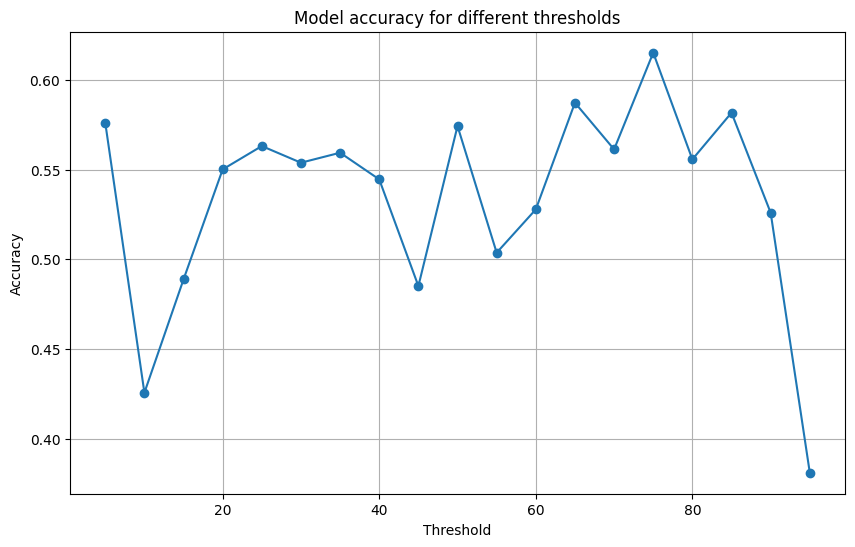

Maximum accuracy:  0.6152416356877324
Corresponding threshold:  75


In [23]:
import matplotlib.pyplot as plt

# Find the maximum accuracy and corresponding threshold
max_accuracy = max(accuracy_for_different_thresholds)
max_threshold = threshold_space[np.argmax(accuracy_for_different_thresholds)]

plt.figure(figsize=(10, 6))
plt.plot(threshold_space, accuracy_for_different_thresholds, marker='o')
plt.title("Model accuracy for different thresholds")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Maximum accuracy: ", max_accuracy)
print("Corresponding threshold: ", max_threshold)

### Try complete GNNs (with multiple GNN layers). Try multiple types of layers

In [52]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, GraphConv

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GNN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):  # Subtract 2 to account for the first and last layers
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        self.layers.append(GCNConv(hidden_dim, output_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        x = self.layers[-1](x, edge_index)  # Last layer

        return F.log_softmax(x, dim=1)


In [54]:
import torch
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv

class GINNet(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GINNet, self).__init__()

        nn1 = Sequential(Linear(num_features, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)

        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)

        self.fc = Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(self.fc(x), dim=1)


In [65]:
def train_model(model, data, device, num_epochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Transfer to GPU
    data = data.to(device)
    model = model.to(device)

    train_mask = torch.arange(data.num_nodes) < (0.8 * data.num_nodes)  # train on the first 80% nodes

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss {loss.item()}')

def test_model(model, data, device):
    model.eval()
    _, pred = model(data).max(dim=1)

    test_mask = torch.arange(data.num_nodes) >= (0.8 * data.num_nodes)  # test on the last 20% nodes

    correct = float(pred[test_mask].eq(data.y[test_mask]).sum().item())
    acc = correct / test_mask.sum().item()

    print(f'Test Accuracy: {acc}')

    return acc


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
input_dim = 30  # initial number of features
hidden_dim = 100  # number of features in hidden layers
output_dim = 19  # number of classes
num_layers = 2  # total number of layers in the network

# model = GNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
model = GINNet(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train and test the model
train_model(model, G, device, num_epochs=400)  # make sure G is a PyTorch Geometric `Data` object
test_model(model, G, device)

Epoch 0: Loss 3.20137357711792
Epoch 10: Loss 1.3776451349258423
Epoch 20: Loss 1.1635388135910034
Epoch 30: Loss 1.039981722831726
Epoch 40: Loss 0.9147174954414368
Epoch 50: Loss 0.8294366002082825
Epoch 60: Loss 0.820489227771759
Epoch 70: Loss 0.7484150528907776
Epoch 80: Loss 0.6593546271324158
Epoch 90: Loss 0.6274212002754211
Epoch 100: Loss 0.5422413945198059
Epoch 110: Loss 0.539577841758728
Epoch 120: Loss 0.5115140080451965
Epoch 130: Loss 0.4215981364250183
Epoch 140: Loss 0.4929366707801819
Epoch 150: Loss 0.35692107677459717
Epoch 160: Loss 0.2810995578765869
Epoch 170: Loss 0.33110347390174866
Epoch 180: Loss 0.24089977145195007
Epoch 190: Loss 0.3551580011844635
Epoch 200: Loss 0.2297280877828598
Epoch 210: Loss 0.16065455973148346
Epoch 220: Loss 0.1282847821712494
Epoch 230: Loss 0.2523382902145386
Epoch 240: Loss 0.14773952960968018
Epoch 250: Loss 0.10283080488443375
Epoch 260: Loss 0.07890016585588455
Epoch 270: Loss 0.07155892997980118
Epoch 280: Loss 0.2103702276

0.5493482309124768

In [64]:
graph = create_graph_from_coordinates(coordinates, 2, expressions_with_id)
G = utils.from_networkx(graph)
G.features = np.array(G.features).astype(float)
features_tensor = torch.tensor(G.features, dtype=torch.float)

# Add the features tensor to the Data object as the 'x' attribute
G.x = features_tensor

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['CELL_TYPE'].to_pandas())
G.y = torch.tensor(y, dtype=torch.long)

G

Data(edge_index=[2, 2688], features=[2688, 30], weight=[2688], num_nodes=2688, x=[2688, 30], y=[2688])